 ## 1. <font color = red> Install and Import the Required Libraries Import the Required Libraries




In [34]:
import sys

# Import all the required Libraries

import pdfplumber

import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb
from IPython.display import display, Markdown
import warnings

warnings.filterwarnings("ignore")

## 2. <font color = red> Read, Process, and Chunk the PDF File

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [3]:
pdf_file = "Principal-Sample-Life-Insurance-Policy.pdf"

#### <font color = red>  2.1 Reading  PDF file and exploring it through pdfplumber

In [6]:
# Open the PDF file
with pdfplumber.open(pdf_file) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[45]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    display(Markdown(text))

PART IV - BENEFITS
Section A - Member Life Insurance
Article 1 - Schedule of Insurance
Subject to the Effective Date provisions of PART III, Section B, and the qualifying provisions of
this Section A, the Scheduled Benefit for an insured Member will be based on his or her class:
Class *Scheduled Benefit
ALL MEMBERS $10,000
However, if a Member has received any payments under the Accelerated Benefits provision as
described in Section A, Article 7, the Scheduled Benefit will be reduced by the amount of such
payment.
*The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART
III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of
insurance approved by The Principal may be different than the Scheduled Benefit. If the
approved amount of insurance is different than the Scheduled Benefit, the approved amount will
apply.
For the age(s) shown below, the amount of a Member's insurance will be the percentage of the
Scheduled Benefit (or approved amount, if applicable) as shown below.
Age % of Scheduled Benefit (or approved
amount, whichever applies)
Age 70 but less than age 75 65%
Age 75 and over 45%
Article 2 - Death Benefits Payable
If a Member dies while insured for Member Life Insurance under this Group Policy, The
Principal will pay his or her beneficiary the Scheduled Benefit (or approved amount, if
applicable) in force on the date of death, less any Accelerated Benefit payment as described in
PART IV, Section A, Article 7. However, if a beneficiary is suspected or charged with the
This policy has been updated effective January 1, 2014
PART IV - BENEFITS
GC 6013 Section A - Member Life Insurance, Page 1

In [7]:
print(tables)

[]


#### <font color = red> 2.2 Extracting text from the PDF

 Extracting text from them using appropriate preprocessing, and store them in a dataframe


In [8]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables


def check_bboxes(word, table_bbox):
    """
        x0	Distance of left side of character from left side of page.
    x1	Distance of right side of character from left side of page
    """
    # Check whether word is inside a table bbox.
    l = word["x0"], word["top"], word["x1"], word["bottom"]
    r = table_bbox
    print(word["x0"])
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [9]:
def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()
            # print(text)
            tables = page.find_tables()
            # print(len(tables))
            table_bboxes = [i.bbox for i in tables]

            tables = [{"table": i.extract(), "top": i.bbox[1]} for i in tables]
            non_table_words = [
                word
                for word in page.extract_words()
                if not any(
                    [check_bboxes(word, table_bbox) for table_bbox in table_bboxes]
                )
            ]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(
                non_table_words + tables, itemgetter("top"), tolerance=10
            ):

                if "text" in cluster[0]:
                    try:
                        lines.append(" ".join([i["text"] for i in cluster]).lower())
                    except KeyError:
                        pass

                elif "table" in cluster[0]:
                    print("Hi")
                    lines.append(json.dumps(cluster[0]["table"]).lower())

            full_text.append([page_no, " ".join(lines)])
            p += 1

    return full_text

In [10]:
tables = []
with pdfplumber.open(pdf_file) as pdf:
    pages = pdf.pages
    for i, pg in enumerate(pages):
        tbl = pages[i].extract_tables()
        print(f"{i} --- {tbl}")

0 --- []
1 --- []
2 --- []
3 --- []
4 --- []
5 --- []
6 --- []
7 --- []
8 --- []
9 --- []
10 --- []
11 --- []
12 --- []
13 --- []
14 --- []
15 --- []
16 --- []
17 --- []
18 --- []
19 --- []
20 --- []
21 --- []
22 --- []
23 --- []
24 --- []
25 --- []
26 --- []
27 --- []
28 --- []
29 --- []
30 --- []
31 --- []
32 --- []
33 --- []
34 --- []
35 --- []
36 --- []
37 --- []
38 --- []
39 --- []
40 --- []
41 --- []
42 --- []
43 --- []
44 --- []
45 --- []
46 --- []
47 --- []
48 --- []
49 --- []
50 --- []
51 --- []
52 --- []
53 --- []
54 --- []
55 --- []
56 --- []
57 --- []
58 --- []
59 --- []
60 --- []
61 --- []
62 --- []
63 --- []


In [321]:
pdf_file[:-4]

'Principal-Sample-Life-Insurance-Policy'

In [322]:
extracted_text = extract_text_from_pdf(pdf_file)

# Convert the extracted list to a PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=["Page No.", "Page_Text"])
extracted_text_df["Document_name"] = pdf_file[:-4]

In [323]:
extracted_text_df

,Page No.,Page_Text,Document_name
0,Page 1,dorothea glause s655 rhode island john doe 01/...,Principal-Sample-Life-Insurance-Policy
1,Page 2,this page left blank intentionally,Principal-Sample-Life-Insurance-Policy
2,Page 3,policy rider group insurance policy no: s655 c...,Principal-Sample-Life-Insurance-Policy
3,Page 4,this page left blank intentionally,Principal-Sample-Life-Insurance-Policy
4,Page 5,principal life insurance company (called the p...,Principal-Sample-Life-Insurance-Policy
...,...,...,...
59,Page 60,i f a dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy
60,Page 61,section d - claim procedures article 1 - notic...,Principal-Sample-Life-Insurance-Policy
61,Page 62,a claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy
62,Page 63,this page left blank intentionally,Principal-Sample-Life-Insurance-Policy


(64, 384)


In [324]:
insurance_pdfs_data = extracted_text_df.copy()
insurance_pdfs_data["Text_Length"] = insurance_pdfs_data["Page_Text"].apply(
    lambda x: len(x.split(" "))
)

In [325]:
display(insurance_pdfs_data)
display(insurance_pdfs_data.info())

,Page No.,Page_Text,Document_name,Text_Length
0,Page 1,dorothea glause s655 rhode island john doe 01/...,Principal-Sample-Life-Insurance-Policy,30
1,Page 2,this page left blank intentionally,Principal-Sample-Life-Insurance-Policy,5
2,Page 3,policy rider group insurance policy no: s655 c...,Principal-Sample-Life-Insurance-Policy,230
3,Page 4,this page left blank intentionally,Principal-Sample-Life-Insurance-Policy,5
4,Page 5,principal life insurance company (called the p...,Principal-Sample-Life-Insurance-Policy,110
...,...,...,...,...
59,Page 60,i f a dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy,285
60,Page 61,section d - claim procedures article 1 - notic...,Principal-Sample-Life-Insurance-Policy,418
61,Page 62,a claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy,322
62,Page 63,this page left blank intentionally,Principal-Sample-Life-Insurance-Policy,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Page No.       64 non-null     object
 1   Page_Text      64 non-null     object
 2   Document_name  64 non-null     object
 3   Text_Length    64 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ KB


None

In [326]:
insurance_pdfs_data.describe()

,Text_Length
count,64.00000
mean,263.62500
std,125.52082
min,5.00000
25%,178.25000
50%,288.00000
75%,361.00000
max,462.00000


<Axes: ylabel='Text_Length'>

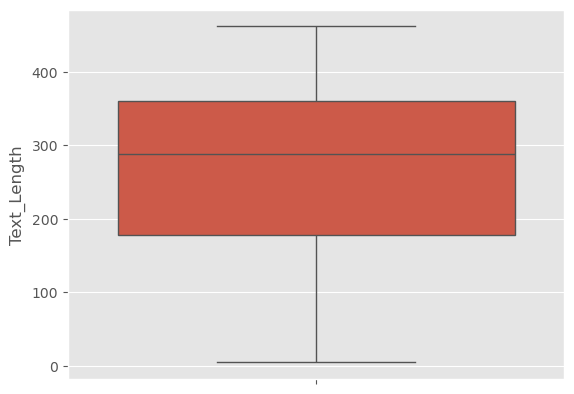

In [327]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.show()
sns.boxplot(insurance_pdfs_data["Text_Length"])

In [328]:
insurance_pdfs_data.Text_Length.describe()

count     64.00000
mean     263.62500
std      125.52082
min        5.00000
25%      178.25000
50%      288.00000
75%      361.00000
max      462.00000
Name: Text_Length, dtype: float64

In [329]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data["Text_Length"] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document_name,Text_Length
0,Page 1,dorothea glause s655 rhode island john doe 01/...,Principal-Sample-Life-Insurance-Policy,30
2,Page 3,policy rider group insurance policy no: s655 c...,Principal-Sample-Life-Insurance-Policy,230
4,Page 5,principal life insurance company (called the p...,Principal-Sample-Life-Insurance-Policy,110
5,Page 6,table of contents part i - definitions part ii...,Principal-Sample-Life-Insurance-Policy,153
6,Page 7,section a – eligibility member life insurance ...,Principal-Sample-Life-Insurance-Policy,176
7,Page 8,section a - member life insurance schedule of ...,Principal-Sample-Life-Insurance-Policy,171
8,Page 9,p art i - definitions when used in this group ...,Principal-Sample-Life-Insurance-Policy,387
9,Page 10,t he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy,251
10,Page 11,(2) has been placed with the member or spouse ...,Principal-Sample-Life-Insurance-Policy,299
11,Page 12,an institution that is licensed as a hospital ...,Principal-Sample-Life-Insurance-Policy,352


In [330]:
insurance_pdfs_data.shape

(60, 4)

##  <font color = 'red'> Generating Embeddings </font>


In [72]:
# Load pre-trained Sentence Transformer model
from sentence_transformers import SentenceTransformer

model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

In [81]:
def generate_embeddings(texts):
    embeddings = embedder.encode(texts)
    return embeddings

In [82]:
def generate_embeddings_on_df(df, column):
    return df[column].apply(lambda x: generate_embeddings([x])[0])

In [83]:
insurance_pdfs_data.columns

Index(['Page No.', 'Page_Text', 'Text_Length'], dtype='object')

In [97]:
# Checkpoint 1
insurance_pdfs_data1 = insurance_pdfs_data.copy()

embeddings = generate_embeddings_on_df(insurance_pdfs_data1, "Page_Text")

In [318]:
embeddings

0     [-0.025921965, 0.04777745, 0.05585773, 0.04239...
2     [-0.105795704, -0.00053023745, 0.016577605, -0...
4     [-0.06354077, 0.058701597, 0.07262767, -0.0272...
5     [-0.0512239, 0.025714073, 0.03712932, -0.04289...
6     [-0.06796548, 0.0066161985, 0.055948853, 0.017...
7     [-0.0504088, 0.058091212, 0.02846623, -0.00059...
8     [-0.013714043, -0.004397424, 0.011242081, 0.04...
9     [-0.064882725, 0.00044504897, 0.024795374, 0.0...
10    [-0.11223651, 0.030973231, -0.014599557, 0.049...
11    [-0.028492585, -0.0008429255, -0.025604283, -0...
12    [-0.044093978, 0.07446205, 0.008301091, -0.039...
13    [-0.06526309, -0.03205171, 0.026287792, -0.004...
14    [-0.14003557, 0.0060381982, -0.067546636, -0.0...
15    [-0.052567292, 0.08995593, 0.052371804, -0.028...
16    [-0.038776368, 0.065445885, 0.005429369, -0.04...
17    [-0.10333701, 0.17144668, 0.00952761, 0.010327...
18    [-0.10471394, 0.1009587, 0.028137662, -0.06776...
19    [-0.03142742, 0.08213159, 0.063443825, -0.

In [99]:
insurance_pdfs_data1["Embeddings"] = embeddings

In [319]:
insurance_pdfs_data1

,Page No.,Page_Text,Text_Length,Embeddings
0,Page 1,dorothea glause s655 rhode island john doe 01/...,30,"[-0.025921965, 0.04777745, 0.05585773, 0.04239..."
2,Page 3,policy rider group insurance policy no: s655 c...,230,"[-0.105795704, -0.00053023745, 0.016577605, -0..."
4,Page 5,principal life insurance company (called the p...,110,"[-0.06354077, 0.058701597, 0.07262767, -0.0272..."
5,Page 6,table of contents part i - definitions part ii...,153,"[-0.0512239, 0.025714073, 0.03712932, -0.04289..."
6,Page 7,section a – eligibility member life insurance ...,176,"[-0.06796548, 0.0066161985, 0.055948853, 0.017..."
7,Page 8,section a - member life insurance schedule of ...,171,"[-0.0504088, 0.058091212, 0.02846623, -0.00059..."
8,Page 9,p art i - definitions when used in this group ...,387,"[-0.013714043, -0.004397424, 0.011242081, 0.04..."
9,Page 10,t he legally recognized union of two eligible ...,251,"[-0.064882725, 0.00044504897, 0.024795374, 0.0..."
10,Page 11,(2) has been placed with the member or spouse ...,299,"[-0.11223651, 0.030973231, -0.014599557, 0.049..."
11,Page 12,an institution that is licensed as a hospital ...,352,"[-0.028492585, -0.0008429255, -0.025604283, -0..."


In [320]:
insurance_pdfs_data1["Embeddings"][0]

array([-2.59219650e-02,  4.77774516e-02,  5.58577292e-02,  4.23974469e-02,
        5.81429303e-02,  1.08498178e-01,  2.88909823e-02, -9.77778528e-03,
       -8.76644701e-02,  2.72514783e-02,  3.77378091e-02,  4.15949523e-02,
       -1.36989942e-02, -6.04695603e-02, -9.53066349e-02, -3.55201140e-02,
       -5.02341054e-02,  1.38775911e-02, -3.82724106e-02,  3.65193225e-02,
        9.49557126e-03,  3.79902720e-02, -6.19149096e-02, -3.33946683e-02,
        3.20348553e-02,  3.44525266e-04,  3.49710844e-02, -4.82039265e-02,
        2.18327697e-02,  2.37846049e-04,  4.61722072e-03, -3.62711623e-02,
       -3.49436626e-02,  4.14841622e-02,  3.39134187e-02, -8.20610952e-03,
       -4.82253246e-02, -3.31781898e-03, -2.51914114e-02,  5.84726743e-02,
       -6.19171187e-02, -4.05921275e-03,  3.89461443e-02,  2.50931121e-02,
       -7.90559202e-02,  2.01821923e-02, -3.81071828e-02, -2.66204569e-02,
        4.70532756e-03,  5.39099574e-02,  8.25184281e-04, -2.82186586e-02,
        2.52994467e-02, -

In [102]:
insurance_pdfs_data["Metadata"] = insurance_pdfs_data.apply(
    lambda x: {"Page_No.": x["Page No."][-2:]}, axis=1
)

In [103]:
insurance_pdfs_data

,Page No.,Page_Text,Text_Length,Metadata
0,Page 1,dorothea glause s655 rhode island john doe 01/...,30,{'Page_No.': ' 1'}
2,Page 3,policy rider group insurance policy no: s655 c...,230,{'Page_No.': ' 3'}
4,Page 5,principal life insurance company (called the p...,110,{'Page_No.': ' 5'}
5,Page 6,table of contents part i - definitions part ii...,153,{'Page_No.': ' 6'}
6,Page 7,section a – eligibility member life insurance ...,176,{'Page_No.': ' 7'}
7,Page 8,section a - member life insurance schedule of ...,171,{'Page_No.': ' 8'}
8,Page 9,p art i - definitions when used in this group ...,387,{'Page_No.': ' 9'}
9,Page 10,t he legally recognized union of two eligible ...,251,{'Page_No.': '10'}
10,Page 11,(2) has been placed with the member or spouse ...,299,{'Page_No.': '11'}
11,Page 12,an institution that is licensed as a hospital ...,352,{'Page_No.': '12'}



## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [104]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()

False

In [105]:
with open("key.txt", "r") as f:
    openai.api_key = f.readline()

In [106]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [107]:
client = chromadb.PersistentClient("../../../")

In [108]:
client.list_collections()

[Collection(name=semantic_search1),
 Collection(name=Policy_Documents),
 Collection(name=my_collection),
 Collection(name=Insurance_Cache1),
 Collection(name=Policy_Documents1),
 Collection(name=deven),
 Collection(name=Insurance_Cache),
 Collection(name=RAG_on_Insurance)]

In [110]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [111]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(
    name="Policy_Documents2", embedding_function=embedding_function
)

In [112]:
documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data["Metadata"].tolist()

In [113]:
metadata_list[2]

{'Page_No.': ' 5'}

In [114]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents=documents_list,
    ids=[str(i) for i in range(0, len(documents_list))],
    metadatas=metadata_list,
)

In [115]:
first = insurance_collection.peek()

In [116]:
first["documents"][0]

'dorothea glause s655 rhode island john doe 01/01/2014 711 high street george ri 02903 group policy for: rhode island john doe all members group member life insurance print date: 07/16/2014'

In [117]:
[(x, y) for x, y in zip(first.keys(), first.values())]

[('ids', ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']),
 ('embeddings',
  array([[-0.02933596,  0.02307248, -0.02638375, ..., -0.03377758,
           0.00728745, -0.00680206],
         [-0.01854883,  0.01305467, -0.00663445, ..., -0.00900489,
          -0.00694199,  0.00362131],
         [-0.01680878,  0.01189401, -0.00690598, ..., -0.02409436,
          -0.01477095,  0.01217371],
         ...,
         [-0.01945642,  0.01036831,  0.01009493, ..., -0.00110351,
          -0.0155758 ,  0.00420067],
         [-0.00365169,  0.02932094, -0.00153972, ..., -0.00111011,
          -0.01510351, -0.00215141],
         [-0.0029149 ,  0.01211939,  0.01349191, ...,  0.01814477,
           0.00149348, -0.02139765]])),
 ('documents',
  ['dorothea glause s655 rhode island john doe 01/01/2014 711 high street george ri 02903 group policy for: rhode island john doe all members group member life insurance print date: 07/16/2014',
   'policy rider group insurance policy no: s655 coverage: life employe

In [118]:
insurance_pdfs_data

,Page No.,Page_Text,Text_Length,Metadata
0,Page 1,dorothea glause s655 rhode island john doe 01/...,30,{'Page_No.': ' 1'}
2,Page 3,policy rider group insurance policy no: s655 c...,230,{'Page_No.': ' 3'}
4,Page 5,principal life insurance company (called the p...,110,{'Page_No.': ' 5'}
5,Page 6,table of contents part i - definitions part ii...,153,{'Page_No.': ' 6'}
6,Page 7,section a – eligibility member life insurance ...,176,{'Page_No.': ' 7'}
7,Page 8,section a - member life insurance schedule of ...,171,{'Page_No.': ' 8'}
8,Page 9,p art i - definitions when used in this group ...,387,{'Page_No.': ' 9'}
9,Page 10,t he legally recognized union of two eligible ...,251,{'Page_No.': '10'}
10,Page 11,(2) has been placed with the member or spouse ...,299,{'Page_No.': '11'}
11,Page 12,an institution that is licensed as a hospital ...,352,{'Page_No.': '12'}


In [119]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids=["0", "1", "2"], include=["embeddings", "documents", "metadatas"]
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-0.02933596,  0.02307248, -0.02638375, ..., -0.03377758,
          0.00728745, -0.00680206],
        [-0.01854883,  0.01305467, -0.00663445, ..., -0.00900489,
         -0.00694199,  0.00362131],
        [-0.01680878,  0.01189401, -0.00690598, ..., -0.02409436,
         -0.01477095,  0.01217371]]),
 'documents': ['dorothea glause s655 rhode island john doe 01/01/2014 711 high street george ri 02903 group policy for: rhode island john doe all members group member life insurance print date: 07/16/2014',
  'policy rider group insurance policy no: s655 coverage: life employer: rhode island john doe effective on the later of the date of issue of this group policy or march 1, 2005, the following will apply to your policy: from time to time the principal may offer or provide certain employer groups who apply for coverage with the principal a financial services hotline and grief support services or any other value added service for the employees o

In [120]:
cache_collection = client.get_or_create_collection(
    name="Insurance_Cache2", embedding_function=embedding_function
)

In [121]:
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': []}

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [122]:
query = input()
print(query)

'I lost my job, I have to undergo surgery, will it be covered?


In [124]:
cache_results = cache_collection.query(query_texts=query, n_results=20)

In [125]:
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[]],
 'distances': [[]]}

In [126]:
results = insurance_collection.query(query_texts=query, n_results=10)

In [127]:
results.keys()

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'included', 'data', 'metadatas', 'distances'])

In [268]:
query = "What are the accidental deaths?".lower()
query2 = "what is the policy on eye issues?".lower()
query3 = "Does the insurance cover diabetic patients?".lower()

In [205]:
def create_data_frame_from_dictionary(d):
    df = pd.DataFrame()
    # keys = d.keys()
    l = [
        (x, y)
        for x, y in zip(d.keys(), d.values())
        if y is not None and x not in ("embeddings", "ids", "included")
    ]

    for x, y in l:

        if x == "embeddings" or x == "ids" or y is None:
            continue
        # print(x,y[0])
        if len(y) == 1:
            df = pd.concat([df, pd.DataFrame.from_dict({x: y[0]})], axis=1)

        else:
            print(y)
            df = pd.concat([df, pd.DataFrame.from_dict({x: y[0][0]})], axis=1)

        # display(df)

    return df

In [238]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search

threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results["distances"][0] == [] or cache_results["distances"][0][0] > threshold:
    # Query the collection against the user query and return the top 10 results
    results = insurance_collection.query(query_texts=query, n_results=10)

    # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
    # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
    Keys = []
    Values = []

    for key, val in results.items():
        if val is None:
            continue
        for i in range(len(results)):
            Keys.append(str(key) + str(i))
            Values.append(str(val[0][i]))

    cache_collection.add(
        documents=[query],
        ids=[
            query
        ],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
        metadatas=dict(zip(Keys, Values)),
    )

    print("Not found in cache. Found in main collection.")

    result_dict = {
        "Metadatas": results["metadatas"][0],
        "Documents": results["documents"][0],
        "Distances": results["distances"][0],
        "IDs": results["ids"][0],
    }
    results_df = pd.DataFrame.from_dict(result_dict)
    # display(results_df)


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results["distances"][0][0] <= threshold:
    cache_result_dict = cache_results["metadatas"][0][0]

    # Loop through each inner list and then through the dictionary
    for key, value in cache_result_dict.items():
        if "ids" in key:
            ids.append(value)
        elif "documents" in key:
            documents.append(value)
        elif "distances" in key:
            distances.append(value)
        elif "metadatas" in key:
            metadatas.append(value)

    print("Found in cache!")

    # Create a DataFrame
    results_df = pd.DataFrame(
        {
            "IDs": ids,
            "Documents": documents,
            "Distances": distances,
            "Metadatas": metadatas,
        }
    )

Found in cache!


In [239]:
results_df

,IDs,Documents,Distances,Metadatas
0,53,"if a member sustains an injury, and as a resul...",0.21631890535354614,{'Page_No.': '57'}
1,29,section e - reinstatement article 1 - reinstat...,0.20722955465316772,{'Page_No.': '54'}
2,10,b. a business assignment; or c. full-time stud...,0.21443426609039307,{'Page_No.': '40'}
3,52,% of scheduled covered loss benefit loss of sp...,0.21782457828521729,{'Page_No.': '13'}
4,54,a . a licensed doctor of medicine (m.d.) or os...,0.20083391666412354,{'Page_No.': '32'}
5,34,(1) marriage or establishment of a civil union...,0.21815717220306396,{'Page_No.': '56'}
6,37,"f . claim requirements listed in part iv, sect...",0.20854467153549194,{'Page_No.': '55'}
7,51,exposure exposure to the elements will be pres...,0.20957398414611816,{'Page_No.': '37'}


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

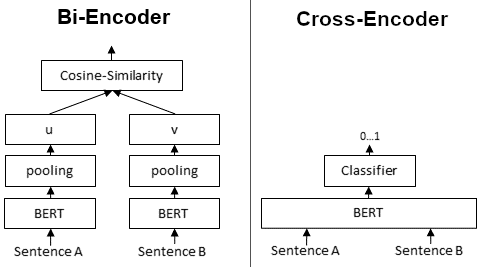

<br>

In [240]:
from sentence_transformers import CrossEncoder, util

cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

In [241]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df["Documents"]]
cross_rerank_scores = cross_encoder.predict(
    cross_inputs,
)

In [242]:
cross_rerank_scores

array([ -9.957413 , -10.261618 , -11.3341675,  -9.038311 , -11.208951 ,
       -10.412862 ,  -9.023835 , -10.772562 ], dtype=float32)

In [243]:
results_df["Reranked_scores"] = cross_rerank_scores

In [244]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,53,"if a member sustains an injury, and as a resul...",0.21631890535354614,{'Page_No.': '57'},-9.957413
1,29,section e - reinstatement article 1 - reinstat...,0.20722955465316772,{'Page_No.': '54'},-10.261618
2,10,b. a business assignment; or c. full-time stud...,0.21443426609039307,{'Page_No.': '40'},-11.334167
3,52,% of scheduled covered loss benefit loss of sp...,0.21782457828521729,{'Page_No.': '13'},-9.038311
4,54,a . a licensed doctor of medicine (m.d.) or os...,0.20083391666412354,{'Page_No.': '32'},-11.208951
5,34,(1) marriage or establishment of a civil union...,0.21815717220306396,{'Page_No.': '56'},-10.412862
6,37,"f . claim requirements listed in part iv, sect...",0.20854467153549194,{'Page_No.': '55'},-9.023835
7,51,exposure exposure to the elements will be pres...,0.20957398414611816,{'Page_No.': '37'},-10.772562


In [245]:
top_3_semantic = results_df.sort_values(by="Distances", ascending=True)
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
4,54,a . a licensed doctor of medicine (m.d.) or os...,0.20083391666412354,{'Page_No.': '32'},-11.208951
1,29,section e - reinstatement article 1 - reinstat...,0.20722955465316772,{'Page_No.': '54'},-10.261618
6,37,"f . claim requirements listed in part iv, sect...",0.20854467153549194,{'Page_No.': '55'},-9.023835


In [246]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by="Reranked_scores", ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
6,37,"f . claim requirements listed in part iv, sect...",0.20854467153549194,{'Page_No.': '55'},-9.023835
3,52,% of scheduled covered loss benefit loss of sp...,0.21782457828521729,{'Page_No.': '13'},-9.038311
0,53,"if a member sustains an injury, and as a resul...",0.21631890535354614,{'Page_No.': '57'},-9.957413


In [247]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [248]:
top_3_RAG

,Documents,Metadatas
6,"f . claim requirements listed in part iv, sect...",{'Page_No.': '55'}
3,% of scheduled covered loss benefit loss of sp...,{'Page_No.': '13'}
0,"if a member sustains an injury, and as a resul...",{'Page_No.': '57'}


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [308]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model


def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.",
        },
        {
            "role": "user",
            "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{results_df}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{results_df}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """,
        },
    ]

    response = openai.chat.completions.create(model="gpt-3.5-turbo", messages=messages)

    return response.choices[0].message.content.split("\n")

In [309]:
# Generate the response

response1 = generate_response(query, top_3_RAG)

In [310]:
# Print the response

display(Markdown("\n".join(response1)))

Accidental deaths refer to fatalities that occur as a result of unforeseen and unintentional events. The insurance policy documents provided do not directly address the definition or specifics of accidental deaths. Therefore, the query "what are the accidental deaths?" is irrelevant to the content of the documents in the dataframe.

I recommend reviewing the specific sections related to accidental deaths in the insurance policy or contacting the insurance provider directly for detailed information on coverage in case of accidental deaths.

**Citations:**
- Policy Name: Not Applicable
- Relevant Page Number(s): Not Applicable

In [311]:
top_3_RAG

,Documents,Metadatas
6,"f . claim requirements listed in part iv, sect...",{'Page_No.': '55'}
3,% of scheduled covered loss benefit loss of sp...,{'Page_No.': '13'}
0,"if a member sustains an injury, and as a resul...",{'Page_No.': '57'}


In [312]:
response2 = generate_response(query2, top_3_RAG)

In [313]:
display(Markdown("\n".join(response2)))

The policy document does not contain specific information on eye issues. I recommend checking other sections or related documents that may cover eye-related policies or conditions.

Citations:
1. Policy Name: Section F - Claim Requirements
   Page Number: 55

2. Policy Name: % of Scheduled Covered Loss Benefit
   Page Number: 13

3. Policy Name: Injury Coverage
   Page Number: 57

In [314]:
top_3_RAG

,Documents,Metadatas
6,"f . claim requirements listed in part iv, sect...",{'Page_No.': '55'}
3,% of scheduled covered loss benefit loss of sp...,{'Page_No.': '13'}
0,"if a member sustains an injury, and as a resul...",{'Page_No.': '57'}


In [315]:
response3 = generate_response(query3, top_3_RAG)

In [316]:
display(Markdown("\n".join(response3)))

The insurance document does not specifically mention coverage for diabetic patients. To find information on coverage for diabetic patients, you may need to refer to specific sections related to medical conditions or exclusions in the insurance policies provided. Here are some policies and page numbers you can refer to for further details:

1. Policy Name: Claim Requirements
   Page Number: 55

2. Policy Name: Scheduled Covered Loss Benefit
   Page Number: 13

3. Policy Name: Member Injury
   Page Number: 57

Please refer to the above policies and search for sections related to medical conditions, coverage limitations, or exclusions for more information on coverage for diabetic patients.

In [317]:
top_3_RAG

,Documents,Metadatas
6,"f . claim requirements listed in part iv, sect...",{'Page_No.': '55'}
3,% of scheduled covered loss benefit loss of sp...,{'Page_No.': '13'}
0,"if a member sustains an injury, and as a resul...",{'Page_No.': '57'}
